In [147]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.feature_selection import RFE

In [148]:
# Load data frame
df = pd.read_csv('data1.csv')

In [149]:
# Display data frame
df

,Mouth_Open_mean,Mouth_Open_std,Mouth_Open_skew,Mouth_Open_median,Mouth_Open_range,Mouth_Closed_mean,Mouth_Closed_std,Mouth_Closed_skew,Mouth_Closed_median,Mouth_Closed_range,...,Right Eyebrow_Raised_skew,Right Eyebrow_Raised_median,Right Eyebrow_Raised_range,Right Eyebrow_Lowered_mean,Right Eyebrow_Lowered_std,Right Eyebrow_Lowered_skew,Right Eyebrow_Lowered_median,Right Eyebrow_Lowered_range,Artificiality,Expressiveness
0,0.001626,0.040292,24.740678,0.0,1,0.998374,0.040292,-24.740678,1.0,1,...,0.0,0.0,0,0.000000,0.00000,0.000000,0.0,0,2,1
1,0.000000,0.000000,0.000000,0.0,0,1.000000,0.000000,0.000000,1.0,0,...,0.0,0.0,0,0.000000,0.00000,0.000000,0.0,0,2,1
2,0.000000,0.000000,0.000000,0.0,0,1.000000,0.000000,0.000000,1.0,0,...,0.0,0.0,0,0.000000,0.00000,0.000000,0.0,0,2,1
3,0.000055,0.007412,134.914788,0.0,1,0.999945,0.007412,-134.914788,1.0,1,...,0.0,0.0,0,0.370454,0.48294,0.536549,0.0,1,2,1
4,0.001260,0.035469,28.125509,0.0,1,0.998740,0.035469,-28.125509,1.0,1,...,0.0,0.0,0,0.000000,0.00000,0.000000,0.0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.008999,0.094439,10.399382,0.0,1,0.991001,0.094439,-10.399382,1.0,1,...,0.0,0.0,0,0.000000,0.00000,0.000000,0.0,0,1,2
76,0.000000,0.000000,0.000000,0.0,0,1.000000,0.000000,0.000000,1.0,0,...,0.0,0.0,0,0.000000,0.00000,0.000000,0.0,0,1,2
77,0.000000,0.000000,0.000000,0.0,0,1.000000,0.000000,0.000000,1.0,0,...,0.0,0.0,0,0.000000,0.00000,0.000000,0.0,0,1,2
78,0.000000,0.000000,0.000000,0.0,0,1.000000,0.000000,0.000000,1.0,0,...,0.0,0.0,0,0.000000,0.00000,0.000000,0.0,0,1,2


In [150]:
# Extract features by dropping target columns from the dataset
X = df.drop(['Expressiveness','Artificiality'], axis=1)  
# Extract target variable 'Artificiality' from the dataset
y = df['Artificiality'] 

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best 'C' value: 1


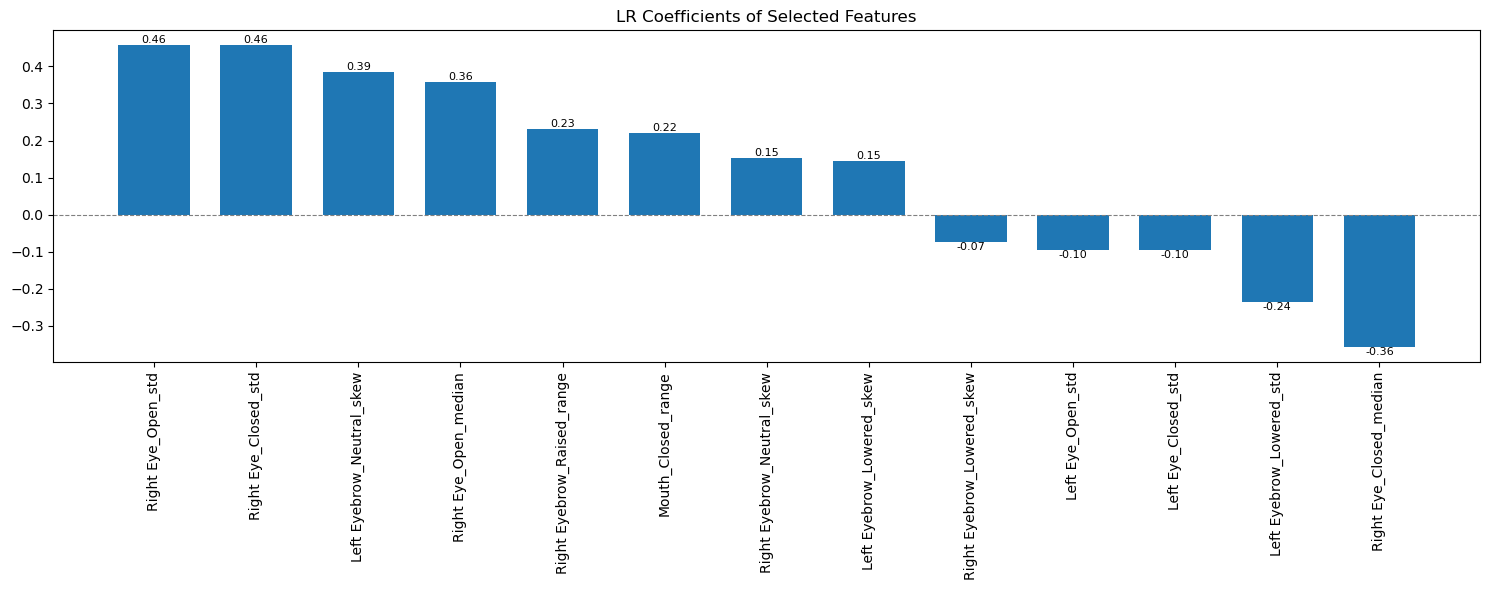

F1 Score on training data with 13 features: 0.6666666666666667
F1 Score on test data with 13 features: 0.631578947368421
Classification Report for Training Data (Logistic Regression):
              precision    recall  f1-score   support

           1       0.68      0.66      0.67        32
           2       0.67      0.69      0.68        32

    accuracy                           0.67        64
   macro avg       0.67      0.67      0.67        64
weighted avg       0.67      0.67      0.67        64

Classification Report for Test Data (Logistic Regression):
              precision    recall  f1-score   support

           1       0.55      0.75      0.63         8
           2       0.60      0.38      0.46         8

    accuracy                           0.56        16
   macro avg       0.57      0.56      0.55        16
weighted avg       0.57      0.56      0.55        16



In [151]:
# Pipeline setup for Logistic Regression with StandardScaler
pipeline_lr = Pipeline([('scaler', StandardScaler()),
                        ('classifier', LogisticRegression(random_state=42, 
                                                            max_iter=1000))
])

# Define cross-validation strategy
cv_strategy_lr = StratifiedKFold(n_splits=10)

# Define the parameter grid for hyperparameter tuning
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1]
}

# Initialize GridSearchCV with the pipeline and the parameter grid
grid_search_lr = GridSearchCV(pipeline_lr,
                                param_grid_lr, 
                                cv=cv_strategy_lr, 
                                scoring='f1', 
                                verbose=1)

# Fit GridSearchCV to find the best hyperparameters
grid_search_lr.fit(X_train, y_train)

# Extract the best hyperparameter value for C and update the pipeline
best_C_lr = grid_search_lr.best_params_['classifier__C']
print(f"Best 'C' value: {best_C_lr}")
pipeline_lr.set_params(classifier__C=best_C_lr)

# Initialize RFECV with the updated pipeline's classifier
selector_lr = RFECV(estimator=pipeline_lr.named_steps['classifier'],
                    step=1,
                    cv=cv_strategy_lr,
                    scoring='f1',
                    min_features_to_select=1
)

# Fit RFECV
selector_lr.fit(X_train, y_train)

# Determine the optimal features
optimal_features_lr = [f for f, s in zip(X_train.columns, selector_lr.support_) if s]

# Fit the pipeline on the training data using optimal features
pipeline_lr.fit(X_train[optimal_features_lr], y_train)

# Plot the LR coefficients for the selected features
if hasattr(pipeline_lr.named_steps['classifier'], "coef_"):
    coefficients = pipeline_lr.named_steps['classifier'].coef_[0]
    indices = np.argsort(coefficients)[::-1]
    names = [optimal_features_lr[i] for i in indices]
    
    plt.figure(figsize=(15, 6))
    plt.title("LR Coefficients of Selected Features")
    bars = plt.bar(range(len(indices)), coefficients[indices], width=0.7)
    plt.xticks(range(len(indices)), names, rotation=90)
    plt.axhline(0, color='grey', linewidth=0.8, linestyle='--')

    # Annotate the bars with the coefficient values
    for bar in bars:
        bar_height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            bar_height,
            f'{bar_height:.2f}',
            ha='center', 
            va='bottom' if bar_height > 0 else 'top',
            fontsize=8
        )

plt.tight_layout()
plt.show()

# Make predictions using the pipeline with optimal features
y_train_pred_lr = pipeline_lr.predict(X_train[optimal_features_lr])
y_test_pred_lr = pipeline_lr.predict(X_test[optimal_features_lr])

# Evaluation
f1_train_lr = f1_score(y_train, y_train_pred_lr, average='binary')
f1_test_lr = f1_score(y_test, y_test_pred_lr, average='binary')

# Output final F1 scores
print(f"F1 Score on training data with {len(optimal_features_lr)} features: {f1_train_lr}")
print(f"F1 Score on test data with {len(optimal_features_lr)} features: {f1_test_lr}")

# Output classification reports
print("Classification Report for Training Data (Logistic Regression):")
print(classification_report(y_train, y_train_pred_lr))
print("Classification Report for Test Data (Logistic Regression):")
print(classification_report(y_test, y_test_pred_lr))

In [152]:
# Create DataFrame of features and coefficients
feature_coefficients_lr = pd.DataFrame({
    'Feature': optimal_features_lr,
    'Coefficient': coefficients
})

# Sort by coefficient magnitude in descending order
feature_coefficients_lr = feature_coefficients_lr.reindex(
    feature_coefficients_lr.Coefficient.abs().sort_values(ascending=False).index
)

# Reset index after sorting
feature_coefficients_lr.reset_index(drop=True, inplace=True)

# Save to CSV
feature_coefficients_lr.to_csv('F_Feature_Coefficients_LR_Artificiality.csv', index=False)

# Display the table
print(feature_coefficients_lr)

                       Feature  Coefficient
0           Right Eye_Open_std     0.456645
1         Right Eye_Closed_std     0.456645
2    Left Eyebrow_Neutral_skew     0.385679
3        Right Eye_Open_median     0.356948
4      Right Eye_Closed_median    -0.356948
5     Left Eyebrow_Lowered_std    -0.235226
6   Right Eyebrow_Raised_range     0.231855
7           Mouth_Closed_range     0.221006
8   Right Eyebrow_Neutral_skew     0.153807
9    Left Eyebrow_Lowered_skew     0.145301
10         Left Eye_Closed_std    -0.096194
11           Left Eye_Open_std    -0.096194
12  Right Eyebrow_Lowered_skew    -0.072436


Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best 'C' value for SVC: 1


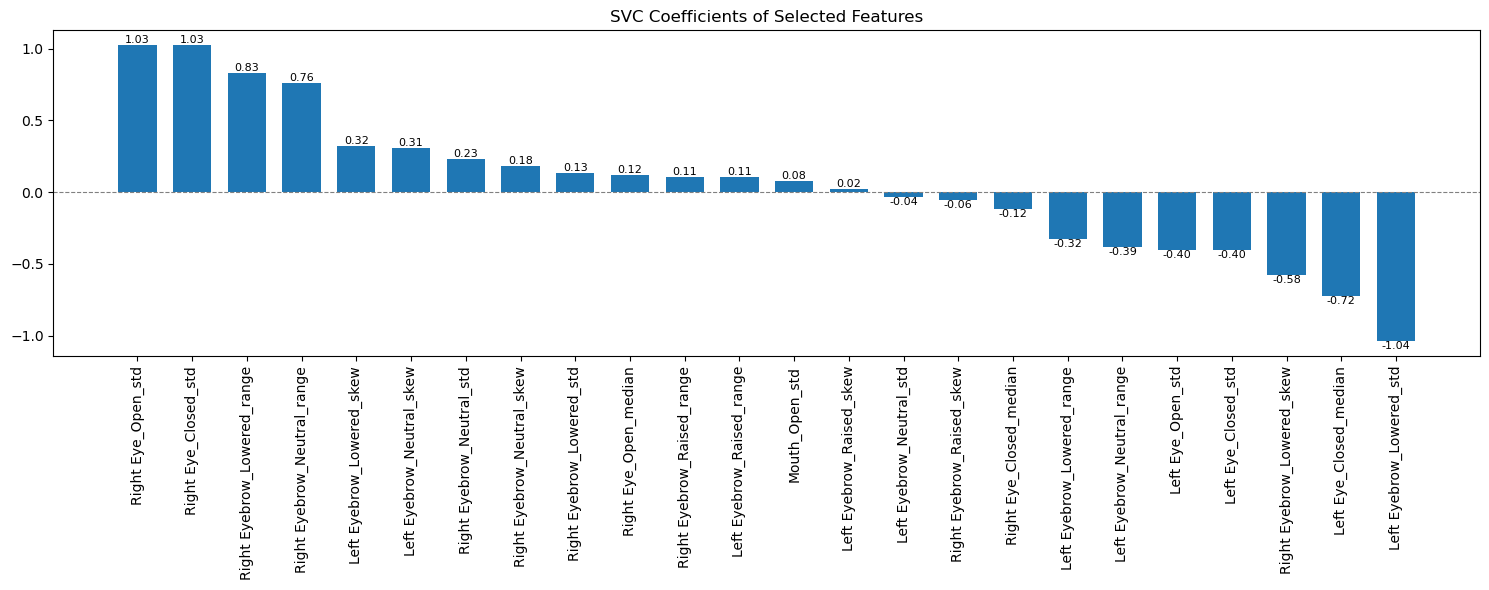

F1 Score on training data with 24 features: 0.7246376811594203
F1 Score on test data with 24 features: 0.7058823529411765
Classification Report for Training Data (SVC):
              precision    recall  f1-score   support

           1       0.68      0.78      0.72        32
           2       0.74      0.62      0.68        32

    accuracy                           0.70        64
   macro avg       0.71      0.70      0.70        64
weighted avg       0.71      0.70      0.70        64

Classification Report for Test Data (SVC):
              precision    recall  f1-score   support

           1       0.67      0.75      0.71         8
           2       0.71      0.62      0.67         8

    accuracy                           0.69        16
   macro avg       0.69      0.69      0.69        16
weighted avg       0.69      0.69      0.69        16



In [153]:
# Pipeline setup for SVC with StandardScaler
pipeline_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(kernel='linear',
                        random_state=42, 
                        probability=False))
])

# Define cross-validation strategy
cv_strategy_svc = StratifiedKFold(n_splits=10)

# Define the parameter grid for hyperparameter tuning
param_grid_svc = {
    'classifier__C': [0.001, 0.01, 0.1, 1]
}

# Initialize GridSearchCV with the pipeline and the parameter grid
grid_search_svc = GridSearchCV(pipeline_svc, 
                                param_grid_svc, 
                                cv=cv_strategy_svc, 
                                scoring='f1', 
                                verbose=1, 
                                n_jobs=-1)

# Fit GridSearchCV to find the best hyperparameters
grid_search_svc.fit(X_train, y_train)

# Extract the best hyperparameter value for C and update the pipeline
best_C_svc = grid_search_svc.best_params_['classifier__C']
print(f"Best 'C' value for SVC: {best_C_svc}")
pipeline_svc.set_params(classifier__C=best_C_svc)

# Initialize RFECV with the updated pipeline's classifier
selector_svc = RFECV(
    estimator=pipeline_svc.named_steps['classifier'],
    step=1,
    cv=cv_strategy_svc,
    scoring='f1',
    min_features_to_select=1
)

# Fit RFECV
selector_svc.fit(X_train, y_train)

# Determine the optimal features
optimal_features_svc = [f for f, s in zip(X_train.columns, selector_svc.support_) if s]

# Fit the pipeline on the optimal features
pipeline_svc.fit(X_train[optimal_features_svc], y_train)

# Plot the SVC coefficients for the selected features
if hasattr(pipeline_svc.named_steps['classifier'], "coef_"):
    coefficients = pipeline_svc.named_steps['classifier'].coef_[0]
    indices = np.argsort(coefficients)[::-1]
    names = [optimal_features_svc[i] for i in indices]
    
    plt.figure(figsize=(15, 6))
    plt.title("SVC Coefficients of Selected Features")
    bars = plt.bar(range(len(indices)), coefficients[indices], width=0.7)
    plt.xticks(range(len(indices)), names, rotation=90)
    plt.axhline(0, color='grey', linewidth=0.8, linestyle='--') 

    # Annotate the bars with the coefficient values
    for bar in bars:
        bar_height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar_height,
            f'{bar_height:.2f}',
            ha='center',
            va='bottom' if bar_height > 0 else 'top',
            fontsize=8 
        )

plt.tight_layout()
plt.show()

# Make predictions using the pipeline
y_train_pred_svc = pipeline_svc.predict(X_train[optimal_features_svc])
y_test_pred_svc = pipeline_svc.predict(X_test[optimal_features_svc])

# Evaluation
f1_train_svc = f1_score(y_train, y_train_pred_svc, average='binary')
f1_test_svc = f1_score(y_test, y_test_pred_svc, average='binary')

# Output F1 scores
print(f"F1 Score on training data with {len(optimal_features_svc)} features: {f1_train_svc}")
print(f"F1 Score on test data with {len(optimal_features_svc)} features: {f1_test_svc}")

# Output classification reports
print("Classification Report for Training Data (SVC):")
print(classification_report(y_train, y_train_pred_svc))
print("Classification Report for Test Data (SVC):")
print(classification_report(y_test, y_test_pred_svc))

In [154]:
# Create DataFrame of features and coefficients
feature_coefficients_svc = pd.DataFrame({
    'Feature': optimal_features_svc,
    'Coefficient': coefficients
})

# Sort by coefficient magnitude in descending order
feature_coefficients_svc = feature_coefficients_svc.reindex(
    feature_coefficients_svc.Coefficient.abs().sort_values(ascending=False).index
)

# Reset index after sorting
feature_coefficients_svc.reset_index(drop=True, inplace=True)

# Save to CSV
feature_coefficients_svc.to_csv('F_Feature_Coefficients_SVC_Artificiality.csv', index=False)

# Display the table
print(feature_coefficients_svc)

                        Feature  Coefficient
0      Left Eyebrow_Lowered_std    -1.040669
1            Right Eye_Open_std     1.025244
2          Right Eye_Closed_std     1.025244
3   Right Eyebrow_Lowered_range     0.829602
4   Right Eyebrow_Neutral_range     0.760954
5        Left Eye_Closed_median    -0.721119
6    Right Eyebrow_Lowered_skew    -0.576850
7           Left Eye_Closed_std    -0.403804
8             Left Eye_Open_std    -0.403804
9    Left Eyebrow_Neutral_range    -0.385255
10   Left Eyebrow_Lowered_range    -0.324166
11    Left Eyebrow_Lowered_skew     0.318477
12    Left Eyebrow_Neutral_skew     0.305278
13    Right Eyebrow_Neutral_std     0.233967
14   Right Eyebrow_Neutral_skew     0.184889
15    Right Eyebrow_Lowered_std     0.133281
16        Right Eye_Open_median     0.121072
17      Right Eye_Closed_median    -0.121072
18   Right Eyebrow_Raised_range     0.106393
19    Left Eyebrow_Raised_range     0.106393
20               Mouth_Open_std     0.075358
21    Righ

                       Feature  Coefficient_LR  Coefficient_SVC  Difference  \
3     Left Eyebrow_Lowered_std       -0.235226        -1.040669    0.805443   
8           Right Eye_Open_std        0.456645         1.025244   -0.568600   
6         Right Eye_Closed_std        0.456645         1.025244   -0.568600   
9   Right Eyebrow_Lowered_skew       -0.072436        -0.576850    0.504414   
0          Left Eye_Closed_std       -0.096194        -0.403804    0.307610   
1            Left Eye_Open_std       -0.096194        -0.403804    0.307610   
5      Right Eye_Closed_median       -0.356948        -0.121072   -0.235875   
7        Right Eye_Open_median        0.356948         0.121072    0.235875   
2    Left Eyebrow_Lowered_skew        0.145301         0.318477   -0.173177   
11  Right Eyebrow_Raised_range        0.231855         0.106393    0.125463   
4    Left Eyebrow_Neutral_skew        0.385679         0.305278    0.080400   
10  Right Eyebrow_Neutral_skew        0.153807      

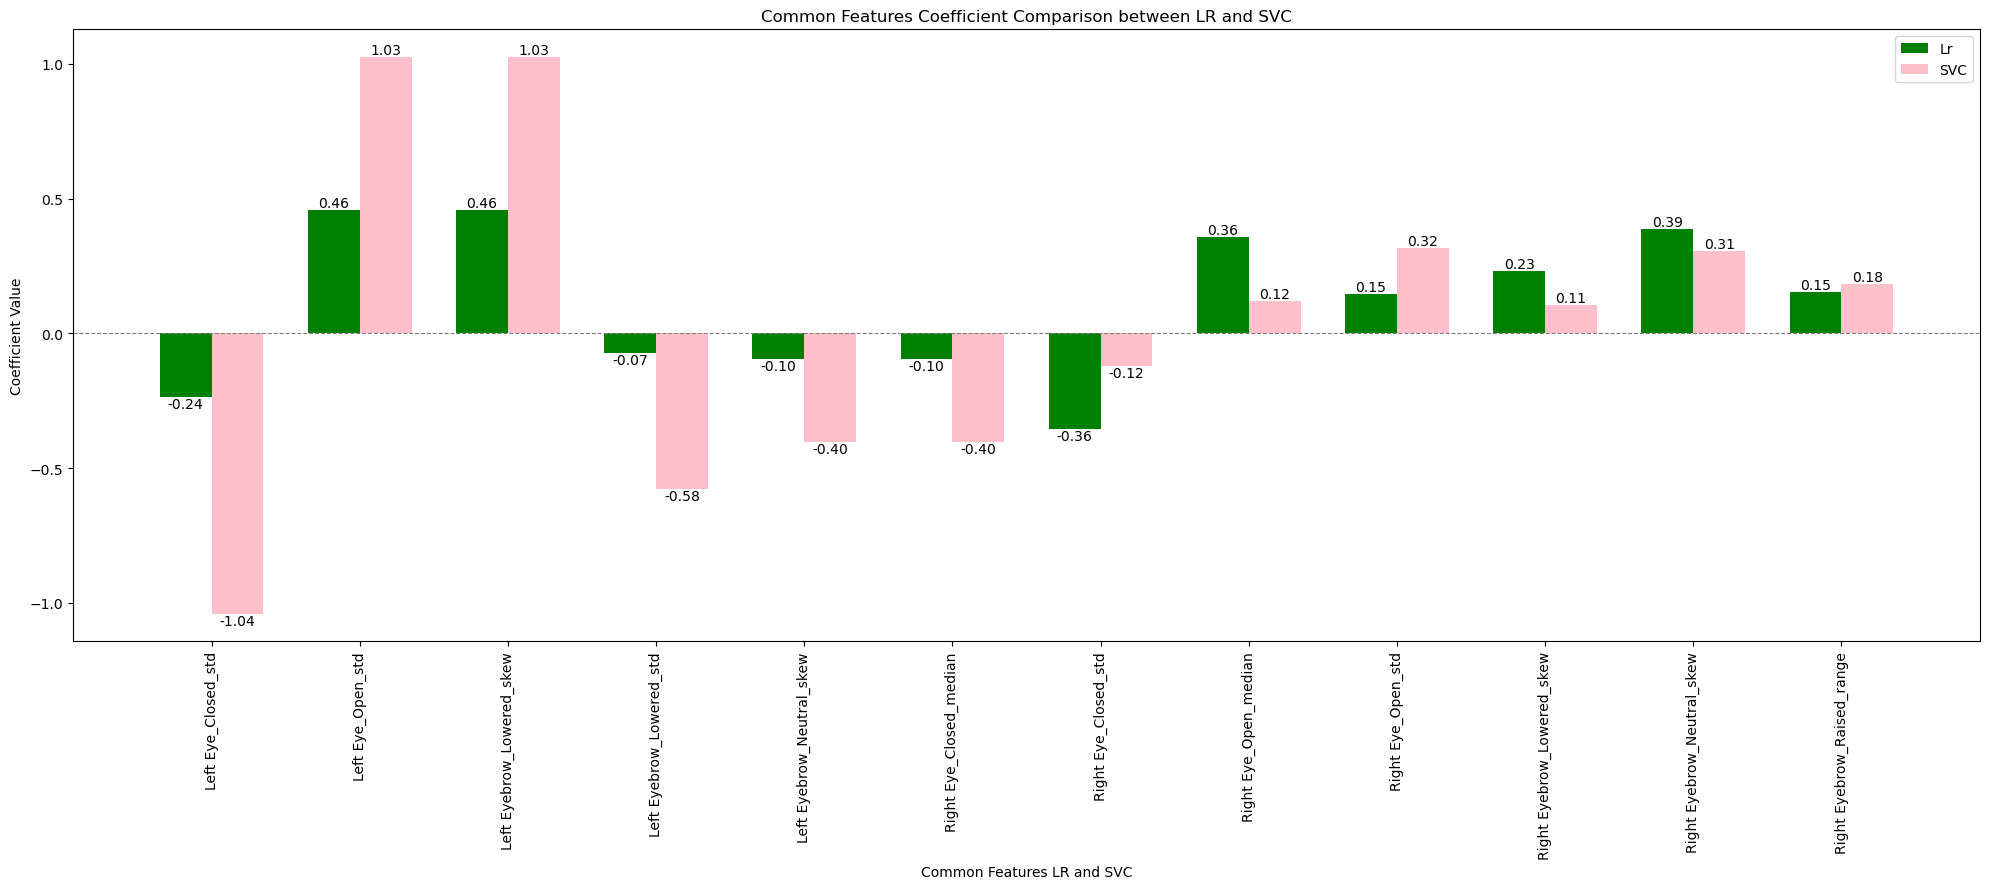

In [155]:
# Aligning the feature sets if necessary
common_features = sorted(list(set(optimal_features_lr) & set(optimal_features_svc)))

# Extract coefficients for the common features in both models
coefficients_lr = [pipeline_lr.named_steps['classifier'].coef_[0][optimal_features_lr.index(f)] for f in common_features]
coefficients_svc = [pipeline_svc.named_steps['classifier'].coef_[0][optimal_features_svc.index(f)] for f in common_features]

# Create a DataFrame with the coefficients
coef_comparison_df = pd.DataFrame({
    'Feature': common_features,
    'Coefficient_LR': coefficients_lr,
    'Coefficient_SVC': coefficients_svc
})

# Calculating the difference in coefficients for each feature
coef_comparison_df['Difference'] = coef_comparison_df['Coefficient_LR'] - coef_comparison_df['Coefficient_SVC']

# Sort the DataFrame by the absolute difference in descending order to see the features with the most discrepancy
coef_comparison_df['Abs_Difference'] = coef_comparison_df['Difference'].abs()
coef_comparison_df = coef_comparison_df.sort_values(by='Abs_Difference', ascending=False)

# Display the DataFrame
print(coef_comparison_df)

# Plot the coefficients for comparison
indices = np.arange(len(common_features))
bar_width = 0.35

plt.figure(figsize=(20, 9))
plt.title("Common Features Coefficient Comparison between LR and SVC")

lr_bars = plt.bar(indices, 
                    coef_comparison_df['Coefficient_LR'], 
                    bar_width, 
                    label='Lr', 
                    color='green')
svc_bars = plt.bar(indices + bar_width, 
                    coef_comparison_df['Coefficient_SVC'], 
                    bar_width, 
                    label='SVC', 
                    color='pink')

# Adding a grey line at y=0
plt.axhline(0, color='grey', linewidth=0.8, linestyle='--')

# Annotating the LR bars
for bar in lr_bars:
    height = bar.get_height()
    offset = 0
    plt.text(bar.get_x() + bar.get_width() / 2, 
             height if height > 0 else height - offset,
             f'{height:.2f}', 
             ha='center', 
             va='bottom' if height > 0 else 'top',
             color='black')

# Annotating the SVC bars
for bar in svc_bars:
    height = bar.get_height()
    offset = 0
    plt.text(bar.get_x() + bar.get_width() / 2, 
             height if height > 0 else height - offset,
             f'{height:.2f}', 
             ha='center', 
             va='bottom' if height > 0 else 'top',
             color='black')

plt.xlabel('Common Features LR and SVC')
plt.ylabel('Coefficient Value')
plt.xticks(indices + bar_width / 2, common_features, rotation=90)
plt.legend()

plt.tight_layout()
plt.show()